## Importación de los datos

In [1]:
## Se importa las librerías necesarias
from pandas import read_csv
from __future__ import print_function
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, accuracy_score
from gmdhpy.gmdh import Classifier
from gmdhpy.plot_model import PlotModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report

from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

## Se importa el dataset con 7 días de latencia
Data = read_csv('data_7dias_latencia.csv', delimiter=',', encoding='cp1252')

## Se elimina las columnas que no son utilizadas en el análisis
del Data['state']
del Data['station']
del Data['date']

## Se almacena en una lista el nombre de las columnas del dataset
col_names=list(Data.columns)

## Se normaliza los datos
mm_scaler=preprocessing.MinMaxScaler()
df_1=mm_scaler.fit_transform(Data)
df=pd.DataFrame(df_1,columns=col_names)

df.head()

,ws,air_temp,visibility,RH,new_cases
0,0.562026,0.807566,0.361702,0.729768,0.094703
1,0.442043,0.191159,0.531915,0.681431,0.096308
2,0.437254,0.106840,0.210402,0.797240,0.891921
3,0.390664,0.814246,0.316306,0.685663,0.121990
4,0.390664,0.814246,0.316306,0.685663,0.020867


### Red neuronal con algoritmo GMDH

train layer0 in 0.06 sec
train layer1 in 0.21 sec
train layer2 in 0.21 sec
train layer3 in 0.21 sec
train layer4 in 0.21 sec
train layer5 in 0.21 sec
train layer6 in 0.29 sec
train layer7 in 0.23 sec
train layer8 in 0.27 sec
train layer9 in 0.26 sec
train layer10 in 0.24 sec
train layer11 in 0.21 sec
train layer12 in 0.21 sec


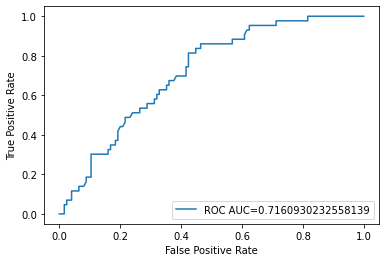

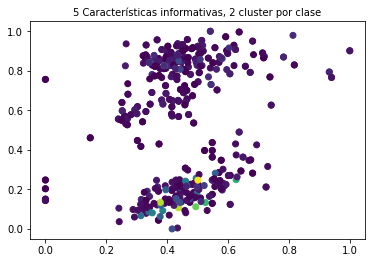

[1, 2, 3]
[0]
Características seleccionadas: index=inp_1 , index=inp_2 , index=inp_3 
Características no seleccionadas: index=inp_0 


In [2]:
if __name__ == '__main__':

    n_informative=5
    n_clusters_per_class=2

    ## Se divide el dataset en datos: variables independientes y variable dependiente (clase)
    array = df.values

    data_x = array[:,0:4]     # Variables independientes
    data_y = array[:,4]       # Variable dependiente (clase)

    ## Se crea la clase binaria 
    label_y = np.where(data_y <=0.0695,0, 1)     # 0: Número bajo de casos covid-19; 1: Número alto de casos covid-19
    
    ## Se crea los conjuntos de datos de entrenamiento y prueba
    train_x, test_x, train_y, test_y = train_test_split(data_x, label_y,
                                                        test_size=0.34,   # 66% datos para entrenar; 34% datos para validación
                                                        random_state=1234)

    ## Se crea los conjuntos de datos de validación
    train_x, validate_x, train_y, validate_y = train_test_split(train_x, train_y,
                                                                test_size=0.50,
                                                                random_state=1234)

    ## Creación del modelo.................................................
    model = Classifier(ref_functions='linear_cov'
                       ,criterion_type='validate'
                       ,criterion_minimum_width=10
                       ,max_layer_count=20
                       ,manual_best_neurons_selection=True
                       ,max_best_neurons_count=5)

    # Entrenamiento del modelo.............................................
    model.fit(train_x, train_y, validation_data=(validate_x, validate_y))
    
    # Predicción del modelo................................................
    pred_y = model.predict_proba(test_x)
  
    ## Curva ROC 
    roc_auc = roc_auc_score(model.le.transform(test_y), pred_y)
    fpr,tpr,_=roc_curve(model.le.transform(test_y), pred_y)
     
    ## Graficar la curva ROC
    plt.plot(fpr,tpr,label="ROC AUC="+str(roc_auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

    ## 
    plt.title("{} Características informativas, {} cluster por clase".format(n_informative, n_clusters_per_class), fontsize='medium')
    plt.scatter(data_x[:, 0], data_x[:, 1], marker='o', c=data_y)
    plt.show()

    print(model.get_selected_features_indices())
    print(model.get_unselected_features_indices())

    print("Características seleccionadas: {}".format(model.get_selected_features()))
    print("Características no seleccionadas: {}".format(model.get_unselected_features()))
    

    PlotModel(model, filename='Modelo_Binario_GMDH', plot_neuron_name=True, view=True).plot()

##### Matriz de confusión

In [8]:
## Se clasifica las predicciones en 0 y 1
pred_y_bin=np.round(pred_y)

# Matriz de confusión de las predicciones de test
confusion_matrix = pd.crosstab(
    test_y.ravel(),
    pred_y_bin,
    rownames=['Real'],
    colnames=['Predicción']
)
confusion_matrix

Predicción,0.0,1.0
Real,,
0,120,5
1,40,3


###### Metricas de precisión

In [9]:
## Reporte del clasificador
clas_report=classification_report(y_true=test_y,y_pred=pred_y_bin)
print(clas_report)

              precision    recall  f1-score   support

           0       0.75      0.96      0.84       125
           1       0.38      0.07      0.12        43

    accuracy                           0.73       168
   macro avg       0.56      0.51      0.48       168
weighted avg       0.65      0.73      0.66       168

